<a href="https://colab.research.google.com/github/cvbrandoe/coursHNS/blob/main/notebooks/ENC_HNS_AnaSpatiale_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP ANALYSE SPATIALE EN PYTHON
Thématique : Accessibilité aux commerces alimentaires et zones d'influence

Méthodes : Analyse de proximité et Diagrammes de Voronoï

## PARTIE 1 : INSTALLATION ET IMPORTS

In [39]:
!pip install osmnx geopandas shapely matplotlib folium scipy numpy pandas overpy

In [40]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import osmnx as ox
import folium
import branca.colormap as cm

## PARTIE 2 : RÉCUPÉRATION DE DONNÉES RÉELLES DEPUIS OPENSTREETMAP

Si vous le souhaitez, choisissez une autre ville.

In [41]:
VILLE = "Nantes, France"

RÉCUPÉRATION DES COMMERCES ALIMENTAIRES

In [42]:
# Commerces alimentaires
tags_commerces = {
'shop': ['supermarket', 'convenience', 'bakery', 'greengrocer',
'butcher', 'fishmonger', 'grocery']
}

commerces = ox.features_from_place(VILLE, tags=tags_commerces)
commerces = commerces.to_crs(epsg=2154)

# Points + centroïdes des polygones
points = commerces[commerces.geometry.type == 'Point'].copy()
polys = commerces[commerces.geometry.type.isin(['Polygon', 'MultiPolygon'])].copy()
polys['geometry'] = polys.geometry.centroid

commerces_gdf = pd.concat([points, polys])
commerces_gdf = gpd.GeoDataFrame(commerces_gdf)
commerces_gdf = commerces_gdf[['name', 'shop', 'geometry']].reset_index(drop=True)

RÉCUPÉRATION DES BÂTIMENTS RÉSIDENTIELS

In [43]:
tags_batiments = {
        'building': ['residential', 'apartments', 'house', 'detached', 'terrace']
}

batiments_osm = ox.features_from_place(VILLE, tags=tags_batiments)

# Convertir en même projection
batiments_osm = batiments_osm.to_crs(epsg=2154)

# Prendre les centroïdes des bâtiments comme points d'habitation
habitations_gdf = gpd.GeoDataFrame(geometry=batiments_osm.geometry.centroid)
habitations_gdf = habitations_gdf.reset_index(drop=True)
habitations_gdf['id'] = range(len(habitations_gdf))

# Échantillonnage si trop de bâtiments (pour la lisibilité)
if len(habitations_gdf) > 1000:
  habitations_gdf = habitations_gdf.sample(n=1000, random_state=42).reset_index(drop=True)
  habitations_gdf['id'] = range(len(habitations_gdf))

print(f"✓ {len(habitations_gdf)} habitations récupérées (échantillonnées si > 1000)")


✓ 1000 habitations récupérées (échantillonnées si > 1000)


DEFINITION DE L'EMPRISE SPATIALE

In [44]:
toutes_geom = pd.concat([
commerces_gdf.geometry,
habitations_gdf.geometry
])

x_min, y_min, x_max, y_max = toutes_geom.total_bounds

marge = 0.05
dx = x_max - x_min
dy = y_max - y_min

zone_bounds = (
x_min - marge * dx,
x_max + marge * dx,
y_min - marge * dy,
y_max + marge * dy
)

print(f"Largeur : {dx/1000:.2f} km")
print(f"Longueur : {dy/1000:.2f} km")
print(f"Surface approx. : {(dx*dy)/1e6:.2f} km²")

Largeur : 9.01 km
Longueur : 12.11 km
Surface approx. : 109.04 km²


## PARTIE 3 : UNE PREMIERE VISUALISATION DES DONNÉES

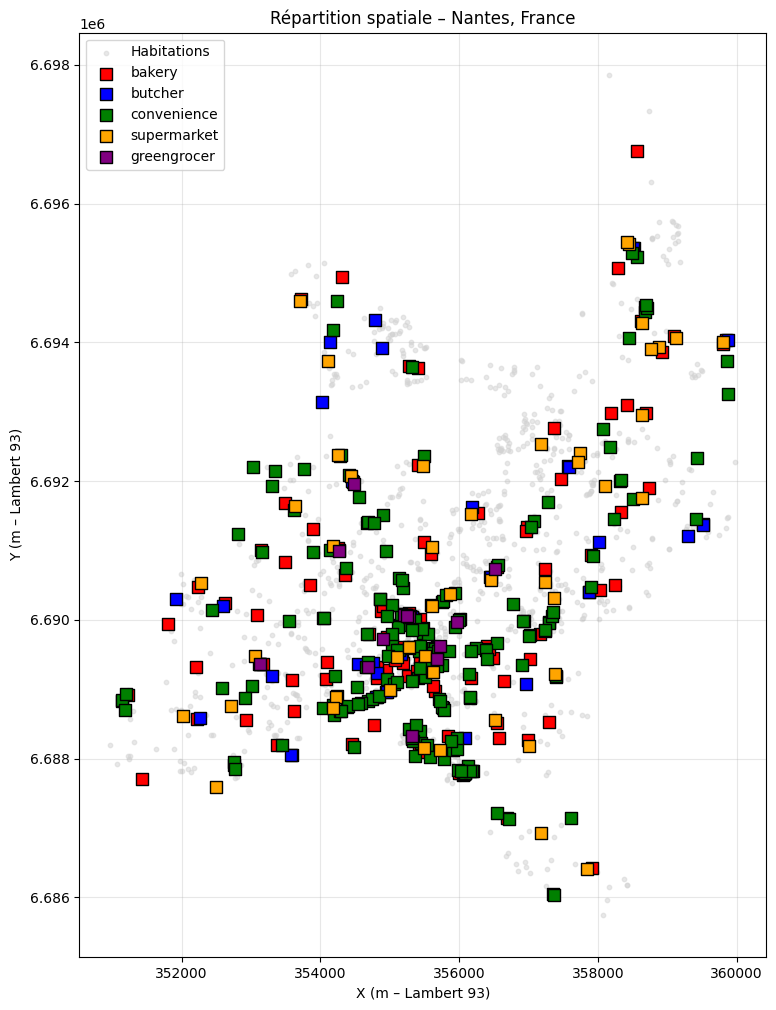

In [45]:
fig, ax = plt.subplots(figsize=(14, 12))

habitations_gdf.plot(
ax=ax, color='lightgray', markersize=10,
alpha=0.5, label='Habitations'
)

# Affichage des commerces par type avec des couleurs différentes
colors = {
    'bakery': 'red',
    'butcher': 'blue',
    'convenience': 'green', #petite épicerie de quartier
    'supermarket': 'orange',
    'greengrocer': 'purple', #primeur
    'Autre commerce alimentaire': 'brown'
}

for commerce_type in commerces_gdf['shop'].unique():
    subset = commerces_gdf[commerces_gdf['shop'] == commerce_type]
    color = colors.get(commerce_type, 'gray')
    subset.plot(ax=ax, color=color, markersize=70,
                marker='s', label=commerce_type,
                edgecolor='black', linewidth=1, zorder=2)

ax.set_xlim(zone_bounds[0], zone_bounds[1])
ax.set_ylim(zone_bounds[2], zone_bounds[3])
ax.set_aspect('equal')
ax.set_xlabel('X (m – Lambert 93)')
ax.set_ylabel('Y (m – Lambert 93)')
ax.set_title(f"Répartition spatiale – {VILLE}")
ax.legend()
ax.grid(True, alpha=0.3)


plt.show()

## PARTIE 4 : ANALYSE DE PROXIMITÉ

L'analyse de proximité étudie les distances entre entités spatiales.

Nous recherchons les deserts alimentaires (ou zones sous-desservies) dans une ville, cela pourrait se traduire en la recherche des habitations éloignées des commerces alimentaires. Nous calculons donc les distances entre habitations et commerces et pouvons ensuite la cartographier.



In [46]:
distances_min = []
commerce_proche = []

for _, hab in habitations_gdf.iterrows():
  dists = commerces_gdf.geometry.distance(hab.geometry)
  idx_min = dists.idxmin()
  distances_min.append(dists.loc[idx_min])
  commerce_proche.append(idx_min)

# Statistiques descriptives
print(f"\nStatistiques sur les distances (en m) :")
print(f"  Moyenne : {np.mean(distances_min):.2f} m")
print(f"  Médiane : {np.median(distances_min):.2f} m")
print(f"  Min : {np.min(distances_min):.2f} m")
print(f"  Max : {np.max(distances_min):.2f} m")
print(f"  Écart-type : {np.std(distances_min):.2f} m")

habitations_gdf['distance_commerce_km'] = np.array(distances_min) / 1000
habitations_gdf['commerce_proche_id'] = commerce_proche


Statistiques sur les distances (en m) :
  Moyenne : 225.59 m
  Médiane : 179.50 m
  Min : 3.99 m
  Max : 1167.18 m
  Écart-type : 184.81 m


In [47]:
seuil_km = 2.0
habitations_gdf['desert_alimentaire'] = (
habitations_gdf['distance_commerce_km'] > seuil_km
)

print(habitations_gdf['desert_alimentaire'].value_counts(normalize=True) * 100)

desert_alimentaire
False    100.0
Name: proportion, dtype: float64


CARTOGRAPHIER LA DISTANCE RESIDENCE / COMMERCE POUR VISUALISER

In [48]:
hab_f = habitations_gdf.to_crs(4326)
com_f = commerces_gdf.to_crs(4326)

centre = hab_f.geometry.unary_union.centroid
centre = gpd.GeoSeries([centre], crs=4326)

m = folium.Map(
location=[centre[0].y, centre[0].x],
zoom_start=14,
tiles='OpenStreetMap'
)

colormap = cm.linear.RdYlGn_11.scale(
hab_f['distance_commerce_km'].min(),
hab_f['distance_commerce_km'].max()
)

for _, row in hab_f.iterrows():
  folium.CircleMarker(
  location=[row.geometry.y, row.geometry.x],
  radius=6,
  fill=True,
  fill_opacity=0.8,
  color='black',
  weight=0.5,
  fill_color=colormap(row['distance_commerce_km'])
).add_to(m)


for _, row in com_f.iterrows():
  folium.CircleMarker(
  location=[row.geometry.y, row.geometry.x],
  radius=3,
  color='black',
  fill=True,
  fill_color='black',
  fill_opacity=1
).add_to(m)

colormap.caption = 'Distance au commerce le plus proche (km)'
colormap.add_to(m)

m

/tmp/ipython-input-3578604589.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centre = hab_f.geometry.unary_union.centroid


# PARTIE 5 : Zones des influence (VORONOI)

THÉORIE : Le diagramme de Voronoï partitionne l'espace en régions.
Chaque région contient tous les points plus proches d'un commerce donné
que de tout autre commerce.

Applications :
- Délimitation des zones de chalandise
- Planification territoriale
- Optimisation de l'implantation de nouveaux commerces

Propriétés mathématiques :
- Les frontières sont des médiatrices entre commerces
- Les sommets sont équidistants de 3+ commerces
- La partition couvre tout l'espace

Préparation des points (coordonnées métriques)

In [49]:
points = np.column_stack([
    commerces_gdf.geometry.x.values,
    commerces_gdf.geometry.y.values
])

Calcul du diagramme de Voronoï

In [50]:
# Ensure commerces_gdf has an 'id' column before proceeding
# This is added here as it's required in zones_influence_gdf and was missing.
if 'id' not in commerces_gdf.columns:
    commerces_gdf['id'] = range(len(commerces_gdf))

from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon

vor = Voronoi(points)

print(f"✓ Diagramme de Voronoï calculé")
print(f"  • Points : {len(vor.points)}")
print(f"  • Régions : {len(vor.regions)}")

✓ Diagramme de Voronoï calculé
  • Points : 415
  • Régions : 416


Fonction robuste : Voronoï borné à l'emprise d'étude

In [51]:
def voronoi_finite_polygons(vor, bbox):
    """Construit des polygones de Voronoï finis, bornés par une bbox."""

    minx, miny, maxx, maxy = bbox
    bbox_poly = Polygon([
        (minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy)
    ])

    regions = []

    for i, region_index in enumerate(vor.point_region):
        vertices = vor.regions[region_index]

        if -1 in vertices or len(vertices) == 0:
            regions.append(None)
            continue

        poly = Polygon(vor.vertices[vertices])
        poly = poly.intersection(bbox_poly)
        regions.append(poly if poly.is_valid else None)

    return regions

Emprise spatiale (bbox métrique)

In [52]:
xmin, ymin, xmax, ymax = commerces_gdf.total_bounds
bbox = (xmin, ymin, xmax, ymax)

polygons = voronoi_finite_polygons(vor, bbox)

GeoDataFrame des zones d'influence

In [53]:
zones_influence_gdf = gpd.GeoDataFrame(
    commerces_gdf[["id", "name", "shop"]], # Removed "surface_m2" and added "id"
    geometry=polygons,
    crs=commerces_gdf.crs
)
zones_influence_gdf = zones_influence_gdf.rename(columns={'shop': 'type'}) # Renamed 'shop' to 'type'

zones_influence_gdf = zones_influence_gdf.dropna(subset=["geometry"])

# Surface en km² (conversion explicite)
zones_influence_gdf["surface_zone_km2"] = zones_influence_gdf.geometry.area / 1_000_000

print("\nStatistiques des zones d'influence :")
print(zones_influence_gdf["surface_zone_km2"].describe().round(2))


Statistiques des zones d'influence :
count    403.00
mean       0.19
std        0.39
min        0.00
25%        0.02
50%        0.06
75%        0.19
max        3.62
Name: surface_zone_km2, dtype: float64


Comptage des habitations par zone (jointure spatiale)

In [54]:
habitations_proj = habitations_gdf.to_crs(commerces_gdf.crs)

join = gpd.sjoin(
    habitations_proj,
    zones_influence_gdf[["id", "geometry"]],
    predicate="within",
    how="left"
)

# Group by the 'id' of the zones_influence_gdf and count habitations
# The 'id' in the `join` DataFrame refers to the `id` of habitations_proj
# We need to group by the `index_right` which refers to the `id` of zones_influence_gdf
counts = join.groupby("index_right").size()
zones_influence_gdf["nb_habitations"] = zones_influence_gdf["id"].map(counts).fillna(0).astype(int)

print("\nHabitations par zone d'influence :")
print(zones_influence_gdf["nb_habitations"].describe())


Habitations par zone d'influence :
count    403.000000
mean       2.392060
std        3.911348
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       40.000000
Name: nb_habitations, dtype: float64


In [55]:
zones_influence_gdf

,id,name,type,geometry,surface_zone_km2,nb_habitations
0,0,Au P'tit Jean,bakery,"POLYGON ((354904.262 6692927.099, 354807.944 6...",0.384024,9
1,1,Boucherie el Baraka,butcher,"POLYGON ((354502.558 6693837.736, 354523.147 6...",0.420965,12
2,2,Le Croquembouche,bakery,"POLYGON ((357271.369 6692254.085, 357510.438 6...",0.206470,8
3,3,Boulangerie de l'Éraudière,bakery,"POLYGON ((357720.197 6692765.872, 357459.799 6...",1.267220,35
4,4,La Boulangerie d'Honoré,bakery,"POLYGON ((354609.339 6691064.867, 354566.379 6...",0.122266,2
...,...,...,...,...,...,...
410,410,Paul,bakery,"POLYGON ((359237.943 6693302.594, 359320.255 6...",0.426713,0
411,411,Hypermarché E.Leclerc,supermarket,"POLYGON ((358408.079 6692835.669, 358593.75 66...",0.161453,3
412,412,Boucherie des Arts,butcher,"POLYGON ((355321.612 6688309.893, 355377.031 6...",0.003496,1
413,413,Ferme de la Forêt,convenience,"POLYGON ((355163.962 6688320.107, 355321.612 6...",0.005556,1


VISUALISATION DES ZONES D'INFLUENCE PAR TYPE ET DENSITE

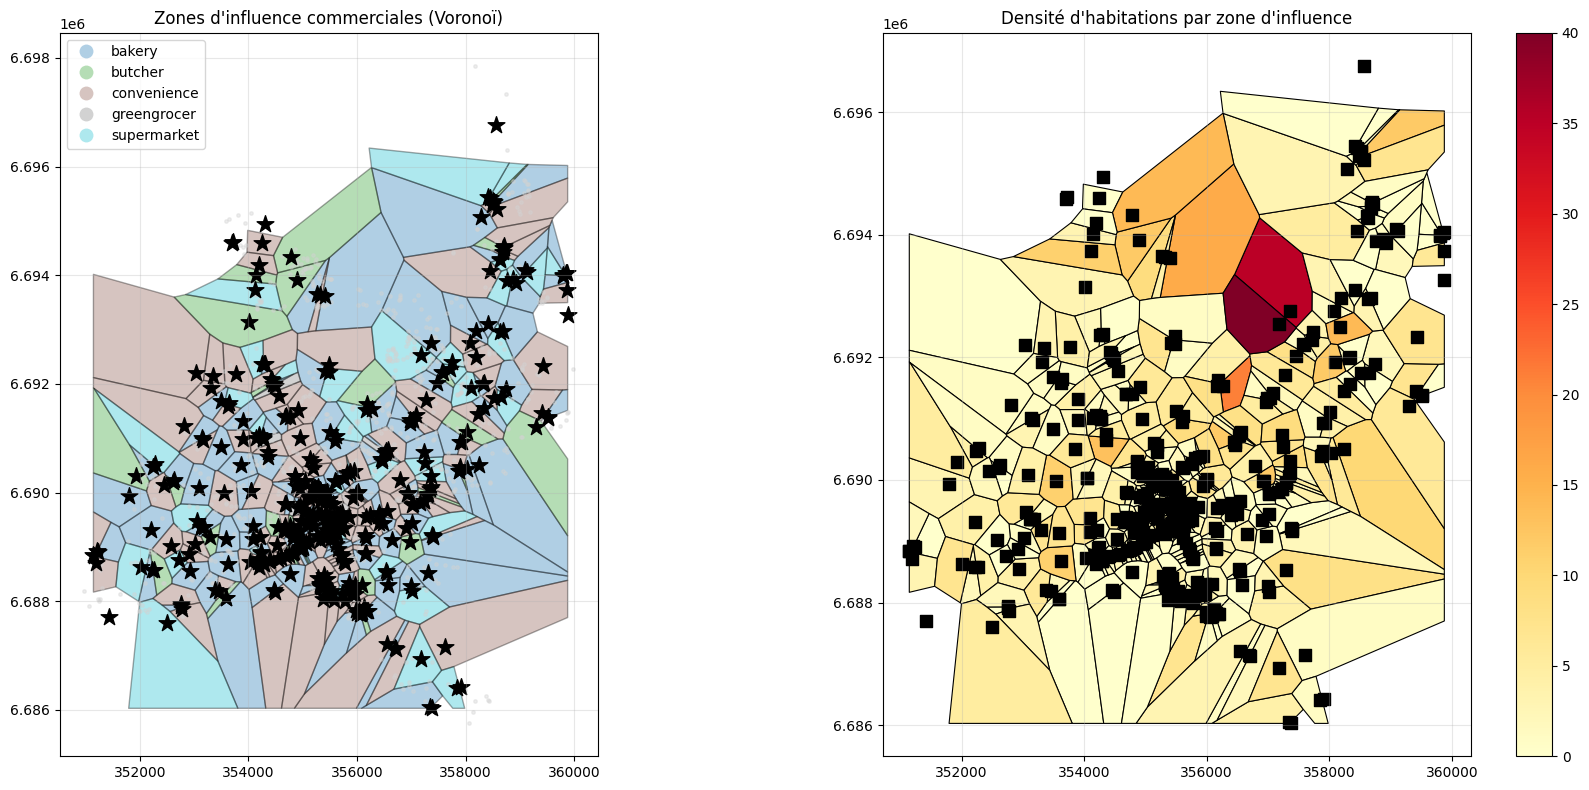

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# --- Carte des zones Voronoï
zones_influence_gdf.plot(
    ax=ax1,
    column="type",
    categorical=True,
    alpha=0.35,
    edgecolor="black",
    legend=True
)

habitations_gdf.plot(ax=ax1, color="lightgray", markersize=6, alpha=0.4)
commerces_gdf.plot(ax=ax1, color="black", marker="*", markersize=160)

ax1.set_title("Zones d'influence commerciales (Voronoï)")
ax1.set_aspect("equal")
ax1.grid(True, alpha=0.3)

# --- Densité d'habitations
zones_influence_gdf.plot(
    ax=ax2,
    column="nb_habitations",
    cmap="YlOrRd",
    legend=True,
    edgecolor="black",
    linewidth=0.8
)

commerces_gdf.plot(ax=ax2, color="black", marker="s", markersize=80)

ax2.set_title("Densité d'habitations par zone d'influence")
ax2.set_aspect("equal")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


D'AUTRES INDICATEURS

In [57]:
zones_influence_gdf["ratio_hab_km2"] = (
    zones_influence_gdf["nb_habitations"] /
    zones_influence_gdf["surface_zone_km2"]
)

print("\nZones sous-desservies (top 3) :")
print(zones_influence_gdf.sort_values("ratio_hab_km2", ascending=False)
      [["id", "type", "ratio_hab_km2"]].head(3).round(1))

print("\nZones sur-desservies (top 3) :")
print(zones_influence_gdf.sort_values("ratio_hab_km2")
      [["id", "type", "ratio_hab_km2"]].head(3).round(1))

print("\n✓ Analyse Voronoï terminée (version SIG cohérente)")


Zones sous-desservies (top 3) :
      id         type  ratio_hab_km2
59    59       bakery         1246.2
157  157      butcher         1161.5
71    71  greengrocer          521.9

Zones sur-desservies (top 3) :
      id    type  ratio_hab_km2
410  410  bakery            0.0
16    16  bakery            0.0
13    13  bakery            0.0

✓ Analyse Voronoï terminée (version SIG cohérente)


VISUALISATION INTERACTIVE DES ZONES D'INFLUENCE (FOLIUM)

In [58]:
# Conversion des GeoDataFrames en CRS 4326 pour Folium
zones_influence_folium = zones_influence_gdf.to_crs(4326)
commerces_folium = commerces_gdf.to_crs(4326)

# Calcul du centre de la zone d'étude pour centrer la carte Folium
centre_lat = zones_influence_folium.geometry.centroid.y.mean()
centre_lon = zones_influence_folium.geometry.centroid.x.mean()

m = folium.Map(location=[centre_lat, centre_lon], zoom_start=12, tiles='OpenStreetMap')

# Création d'une colormap pour le ratio d'habitations par km²
# Utilisation d'une colormap diverging pour mieux visualiser les variations autour d'une moyenne
# On s'assure que la min et max sont valides
ratio_min = zones_influence_folium['ratio_hab_km2'].min()
ratio_max = zones_influence_folium['ratio_hab_km2'].max()

if ratio_min == ratio_max:
    # Si toutes les valeurs sont les mêmes, on utilise une colormap simple ou une couleur unie
    colormap_ratio = cm.linear.YlGnBu_09.scale(0, 1)
else:
    colormap_ratio = cm.linear.YlGnBu_09.scale(ratio_min, ratio_max)

# Ajout des zones de Voronoï à la carte
folium.GeoJson(
    zones_influence_folium.to_json(),
    style_function=lambda x: {
        'fillColor': colormap_ratio(x['properties']['ratio_hab_km2']),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['name', 'type', 'surface_zone_km2', 'nb_habitations', 'ratio_hab_km2'],
        aliases=['Commerce', 'Type', 'Surface (km²)', 'Nb Habitations', 'Ratio Hab/km²'],
        localize=True
    )
).add_to(m)

# Ajout des commerces à la carte
for idx, row in commerces_folium.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=1,
        tooltip=f"{row['name']} ({row['shop']})"
    ).add_to(m)

# Ajout de la légende
colormap_ratio.caption = 'Ratio Habitations par km²'
colormap_ratio.add_to(m)

# Affichage de la carte
m

/tmp/ipython-input-3440906496.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centre_lat = zones_influence_folium.geometry.centroid.y.mean()
/tmp/ipython-input-3440906496.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centre_lon = zones_influence_folium.geometry.centroid.x.mean()
